In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#os and i/o
import os
import numpy as np
import glob
from os.path import abspath
import csv

#scientific computing
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats, optimize
from pandas import DataFrame, Series
from moss import glm
import seaborn as sns
import random as rd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import scipy.stats

#ipython add-ons
from IPython.parallel import Client
from IPython.display import Image
import multiprocessing

##nipype
import nibabel as nib
from nipype.pipeline.engine import Node, MapNode, Workflow
from nipype.interfaces.io import DataGrabber, DataFinder, DataSink
from nipype.interfaces import fsl
from nipype.interfaces.fsl import ImageMeants
from nipype.interfaces.fsl import ImageStats

%matplotlib inline

In [2]:
%matplotlib inline

## Preprocessed data

In [3]:
var_file = '/Volumes/awagner/klarocqu/eccentricity2/analysis/{exp}/{subj}/model/unsmoothed/run_{run}/{stat}.nii.gz'
mean_file = '/Volumes/awagner/klarocqu/eccentricity2/analysis/{exp}/{subj}/preproc/run_{run}/mean_func.nii.gz'
mask_file = '/Volumes/awagner/klarocqu/eccentricity2/analysis/{exp}/{subj}/preproc/run_{run}/functional_mask.nii.gz'

In [4]:
def get_slice_vals(subj, run, exp, stat, sp, mp):
    
    stat_data = nib.load(sp.format(exp=exp, subj=subj, run=run, stat=stat)).get_data()
    mask_data = nib.load(mp.format(exp=exp, subj=subj, run=run)).get_data().astype(bool)

    slice_stat = np.zeros(stat_data.shape[-1])
    for z in np.arange(stat_data.shape[-1], dtype=int):
        slice_stat[z] = stat_data[..., z][mask_data[..., z]].mean()

    return slice_stat

In [5]:
subjects = ['sub11', 'sub12', 'sub14', 'sub15']
runs = [1,2]
experiments = ['localizer', 'retinotopy']

### tSNR

/Users/anthonywagner/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


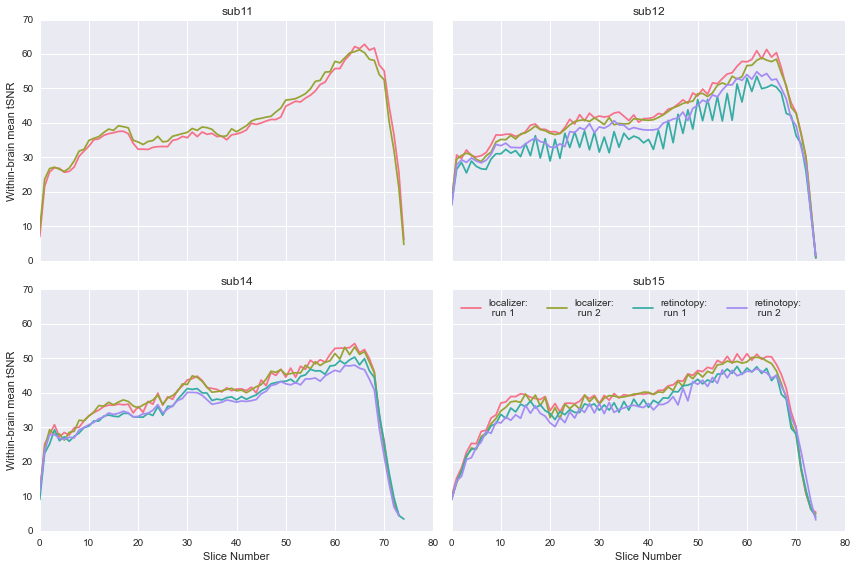

In [6]:
with sns.color_palette("husl", 4):
    f, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
for ax, subj in zip(axes.flat, subjects):
    for exp in experiments:
        for run in runs:
            try:
                ax.plot(get_slice_vals(subj, run, exp, 'tsnr', var_file, mask_file), label='{}:\n run {}'.format(exp, run))
                ax.set(title=subj)
            except:
                pass
ax.legend(loc="upper left", ncol=4)
plt.setp(axes[-1], xlabel="Slice Number")
plt.setp(axes[:, 0], ylabel="Within-brain mean tSNR")
f.tight_layout()

### Residual SS

Note, model for scans labeled 'retinotopy' only consists of motion regressors. 

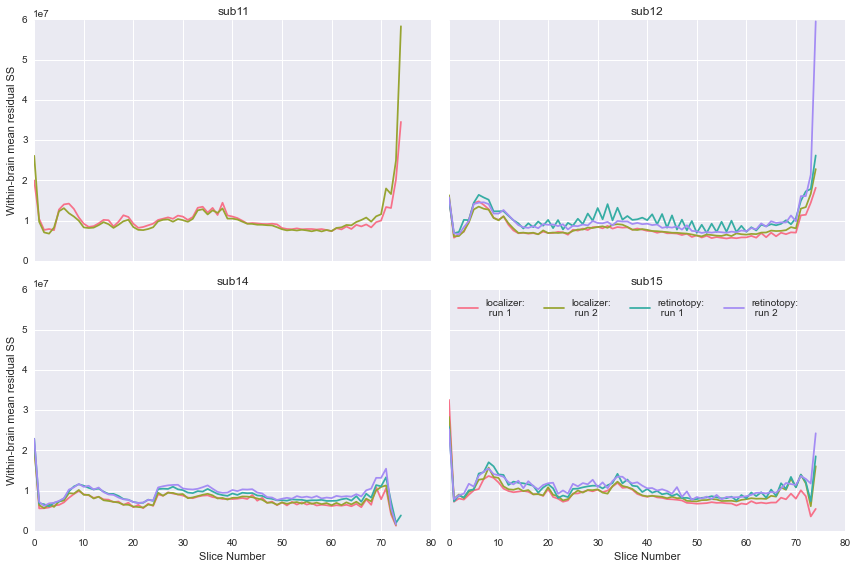

In [7]:
with sns.color_palette("husl", 4):
    f, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
for ax, subj in zip(axes.flat, subjects):
    for exp in experiments:
        for run in runs:
            try:
                ax.plot(get_slice_vals(subj, run, exp, 'ssres_full', var_file, mask_file), label='{}:\n run {}'.format(exp, run))
                ax.set(title=subj)
            except:
                pass
ax.legend(loc="upper left", ncol=4)
plt.setp(axes[-1], xlabel="Slice Number")
plt.setp(axes[:, 0], ylabel="Within-brain mean residual SS")
f.tight_layout()

### Mean map

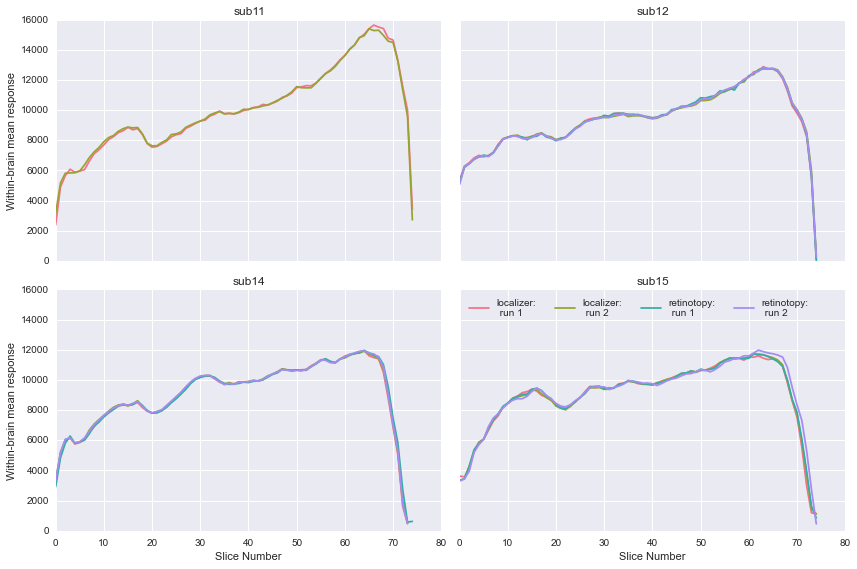

In [8]:
with sns.color_palette("husl", 4):
    f, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
for ax, subj in zip(axes.flat, subjects):
    for exp in experiments:
        for run in runs:
            try:
                ax.plot(get_slice_vals(subj, run, exp, None, mean_file, mask_file), label='{}:\n run {}'.format(exp, run))
                ax.set(title=subj)
            except:
                pass
ax.legend(loc="upper left", ncol=4)
plt.setp(axes[-1], xlabel="Slice Number")
plt.setp(axes[:, 0], ylabel="Within-brain mean response")
f.tight_layout()

## Unpreprocessed data

### Multiband

In [3]:
mask_temp = '/home/iballard/fd/analysis/{}/{}/preproc/run_{}/functional_mask.nii.gz'
full_temp = '/home/iballard/fd/data/{}/func/{}/run_{}.nii.gz'

In [4]:
def get_slice_tsnr(in_tuple):
    subj, run, exp, exp_mask = in_tuple
    f1 = mask_temp.format(exp_mask, subj, run)
    f2 = full_temp.format(subj, exp, run)
    if os.path.exists(f1) and os.path.exists(f2):
        fd = nib.load(full_temp.format(subj, exp, run)).get_data()
        fd_sd = fd[...,8:-20].std(axis=-1)
        fd_mean = fd[...,8:-20].mean(axis=-1)
        fd_tsnr = fd_mean / fd_sd

        mask_data = nib.load(mask_temp.format(exp_mask, subj, run)).get_data().astype(bool)

        zs = np.arange(fd_tsnr.shape[-1], dtype=int)

        slice_tsnr = np.zeros(fd_tsnr.shape[-1])
        for z in zs:
            slice_tsnr[z] = np.nanmean(fd_tsnr[..., z][mask_data[..., z]])
    else:
        slice_tsnr = np.NaN
    return (in_tuple,slice_tsnr)

In [5]:
home_dir = '/data/home/iballard/fd/'
subj_file = home_dir + 'subjects.txt'
sub_list = list(np.loadtxt(subj_file,'string'))
runs = [1,2,3]
experiments_long = ['ser_4mm', 'sim_4mm'] 
experiments = ['ser', 'sim'] 
# experiments_long = ['localizer', 'retinotopy']

In [6]:
in_tuples = []
for sub in sub_list:
    for run in runs:
        for exp, expl in zip(experiments, experiments_long):
            in_tuples.append((sub,run,exp,expl))

In [7]:
import multiprocessing
pool = multiprocessing.Pool(processes = 12)
output = pool.map(get_slice_tsnr,in_tuples)
pool.terminate()
pool.join()

In [10]:
tsnr_dict = {}
for o in output:
    key,val = o
    tsnr_dict[key] = val
print len(sub_list)

32


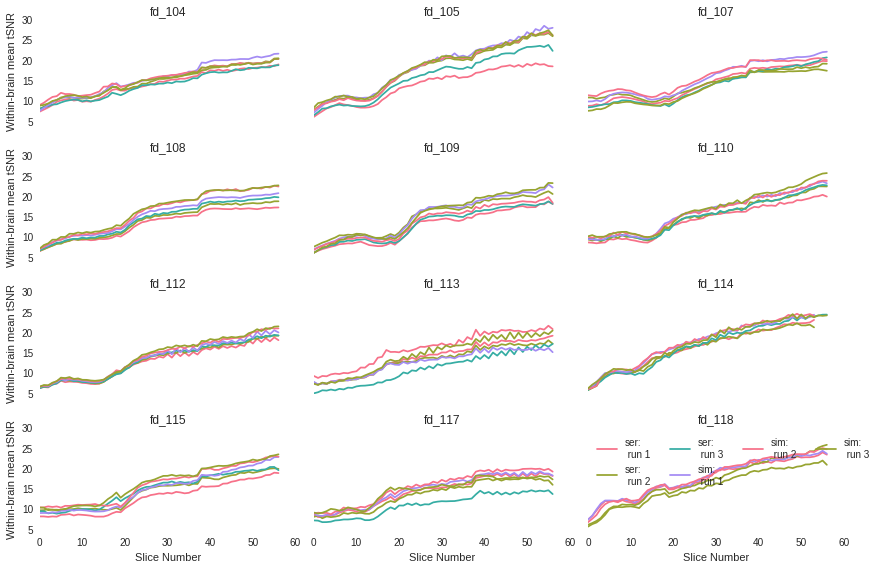

In [32]:
with sns.color_palette("husl", 4):
    f, axes = plt.subplots(4, 3, figsize=(12, 8), sharex=True, sharey=True)
for ax, subj in zip(axes.flat, sub_list):
    for exp, expl in zip(experiments, experiments_long):
        for run in runs:
#             try:
            ax.plot(tsnr_dict[(subj, run, exp, expl)], label='{}:\n run {}'.format(exp, run))
            ax.set(title=subj)
#             except:
#                 pass
ax.legend(loc="upper left", ncol=4)
plt.setp(axes[-1], xlabel="Slice Number")
plt.setp(axes[:, 0], ylabel="Within-brain mean tSNR")
f.tight_layout()
plt.savefig(home_dir + '/tsnr.png')

### Single band

In [13]:
subjects = ['sub11', 'sub12', 'sub14', 'sub15']
runs = [1,2,3,4,5,6]
experiments = ['enc'] 
experiments_long = ['encoding']

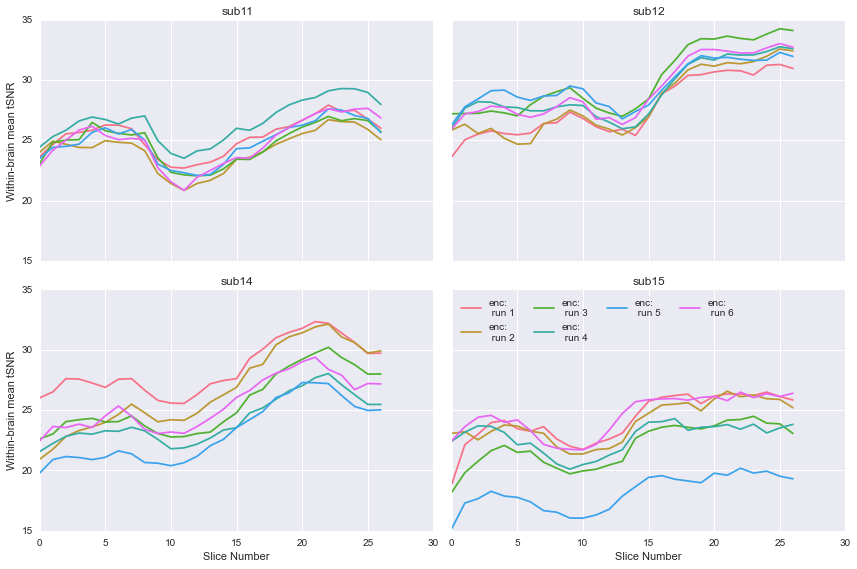

In [63]:
with sns.color_palette("husl", 6):
    f, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
for ax, subj in zip(axes.flat, subjects):
    for exp, expl in zip(experiments, experiments_long):
        for run in runs:
            try:
                ax.plot(get_slice_tsnr(subj, run, exp, expl), label='{}:\n run {}'.format(exp, run))
                ax.set(title=subj)
            except:
                pass
ax.legend(loc="upper left", ncol=4)
plt.setp(axes[-1], xlabel="Slice Number")
plt.setp(axes[:, 0], ylabel="Within-brain mean tSNR")
f.tight_layout()

In [69]:
def get_slice_func(subj, run, exp, exp_mask, func):
    
    fd = nib.load(full_temp.format(subj, exp, run)).get_data()
    fd_stat = func(fd[...,8:], axis=-1)

    mask_data = nib.load(mask_temp.format(exp_mask, subj, run)).get_data().astype(bool)

    zs = np.arange(fd_tsnr.shape[-1], dtype=int)

    slice_stat = np.zeros(fd_tsnr.shape[-1])
    for z in zs:
        slice_stat[z] = fd_stat[..., z][mask_data[..., z]].mean()

    return slice_stat

### Standard deviation

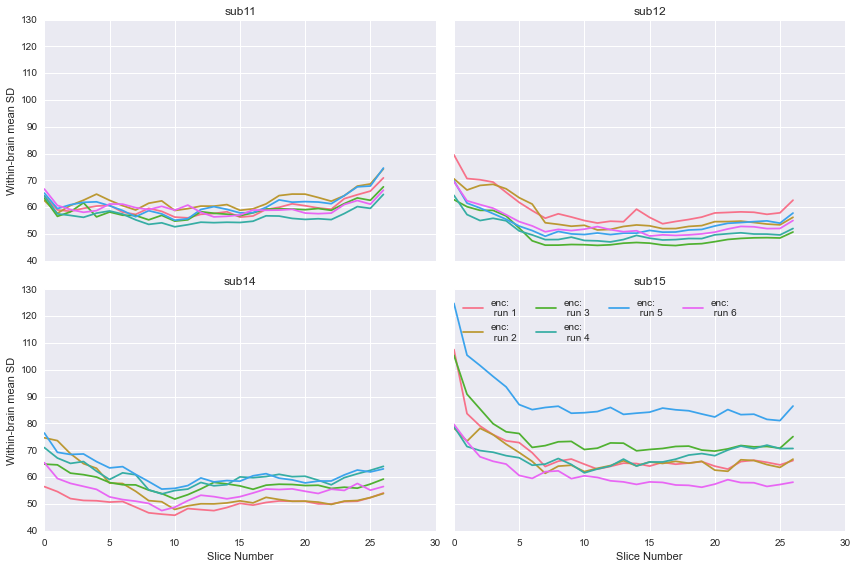

In [73]:
with sns.color_palette("husl", 6):
    f, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
for ax, subj in zip(axes.flat, subjects):
    for exp, expl in zip(experiments, experiments_long):
        for run in runs:
            try:
                ax.plot(get_slice_func(subj, run, exp, expl, np.std), label='{}:\n run {}'.format(exp, run))
                ax.set(title=subj)
            except:
                pass
ax.legend(loc="upper left", ncol=4)
plt.setp(axes[-1], xlabel="Slice Number")
plt.setp(axes[:, 0], ylabel="Within-brain mean SD")
f.tight_layout()

#### Move x-axis to same scale as multiband

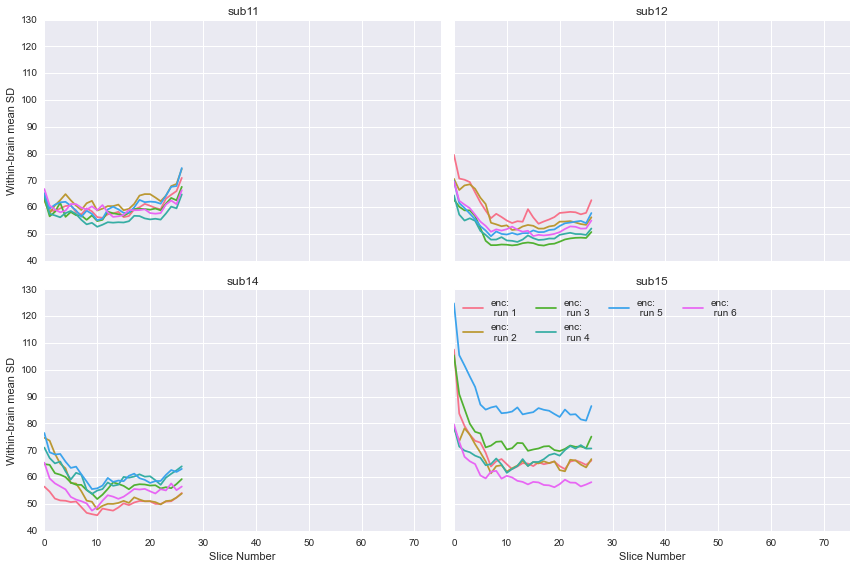

In [110]:
with sns.color_palette("husl", 6):
    f, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
for ax, subj in zip(axes.flat, subjects):
    for exp, expl in zip(experiments, experiments_long):
        for run in runs:
            try:
                ax.plot(get_slice_func(subj, run, exp, expl, np.std), label='{}:\n run {}'.format(exp, run))
                ax.set(title=subj)
            except:
                pass
ax.legend(loc="upper left", ncol=4)
plt.setp(axes[-1], xlabel="Slice Number")
plt.setp(axes[:, 0], ylabel="Within-brain mean SD")
plt.setp(axes[:,:],xlim=(0,75))
f.tight_layout()

### Mean

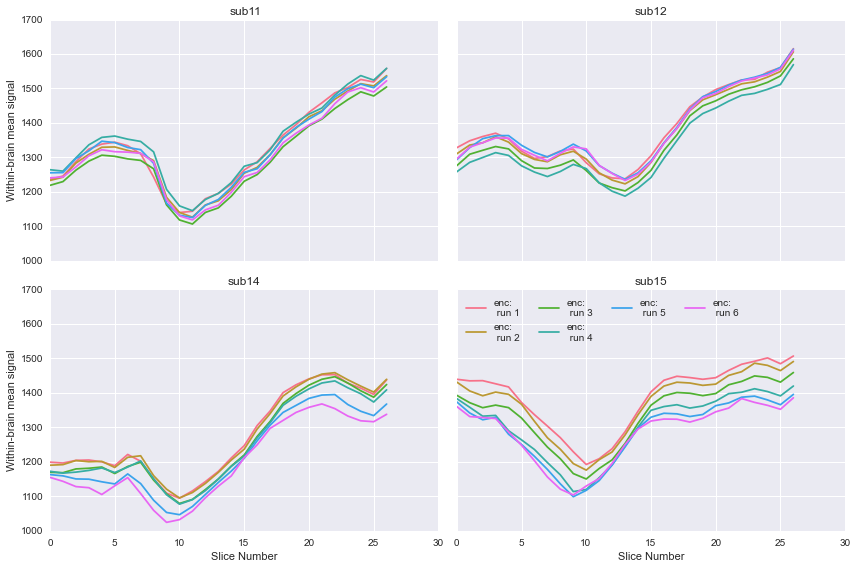

In [111]:
with sns.color_palette("husl", 6):
    f, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)
for ax, subj in zip(axes.flat, subjects):
    for exp, expl in zip(experiments, experiments_long):
        for run in runs:
            try:
                ax.plot(get_slice_func(subj, run, exp, expl, np.nanmean), label='{}:\n run {}'.format(exp, run))
                ax.set(title=subj)
            except:
                pass
ax.legend(loc="upper left", ncol=4)
plt.setp(axes[-1], xlabel="Slice Number")
plt.setp(axes[:, 0], ylabel="Within-brain mean signal")
f.tight_layout()